# Importing Libraries

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from kaggle.api.kaggle_api_extended import KaggleApi
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_validate


# Downloading Dataset 

## Initializing  Kaggle API

In [ ]:
API = KaggleApi() # Creating an instance of the object
API.authenticate() # Authenticating the API

## Specifying & Downloading Dataset

In [ ]:
path = 'dubradave/hospital-readmissions' # Extarcting dataset path and name from Kaggle 
API.dataset_download_files(dataset, unzip=True) # Downloading the dataset

# Importing Dataset

In [3]:
dataset = pd.read_csv('hospital_readmissions.csv') # Importing dataset
dataset.head() # Printing first 4 rows of the dataset

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no


# Exploratory Data Analysis

## Calculating Missing Values 

In [4]:
print("Missing values in the dataset:", dataset.isnull().values.sum())

Missing values in the dataset: 0


## Patient's Age Group

In [5]:
age = pd.Series(dataset['age']) # Extracting age group in patient's from the dataset in the form of 'series'
age_counter = age.value_counts() # Counting the patient in each age-gorup

In [6]:
labels = ['Age-Group: 70-80', 'Age-Group: 60-70', 'Age-Group: 80-90', 'Age-Group: 50-60', 'Age-Group: 40-50', 'Age-Group: 90-100'] # Intializing labels for the chart
colors = ['green', 'yellow', 'red', 'purple', 'pink', 'skyblue'] # Initialzing colors for each percentage 

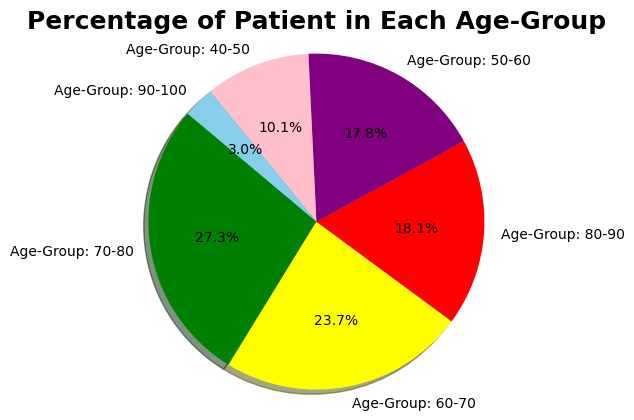

In [7]:
plt.pie(age_counter, labels = labels, colors = colors, autopct = '%1.1f%%', shadow = True, startangle = 140) # Setting the pie chart
plt.axis('equal')  # Setting chart axis as 'equal' to ensures that the pie is drawn as a circle.
plt.title('Percentage of Patient in Each Age-Group', fontsize = 18, fontweight = 'bold') # Chart Title
plt.show() # Displaying the chart

## Outliers

In [8]:
time = dataset['time_in_hospital'].to_numpy() # Extracting 'time_in_hospital' data
proc = dataset['n_procedures'].to_numpy() # Extracting 'number_of_procedures' data
lab_proc = dataset['n_lab_procedures'].to_numpy() # Extracting 'number_of_lab_procedures data
medic = dataset['n_medications'].to_numpy() # Extracting 'number_of_medication' data
outpatient = dataset['n_outpatient'].to_numpy() # Extracting 'number_of_out_patient' data
inpatient = dataset['n_inpatient'].to_numpy() # Extracting 'number_of_inpatient' data
emergency = dataset['n_emergency'].to_numpy() # Extracting 'number_of_emergency_visits' data

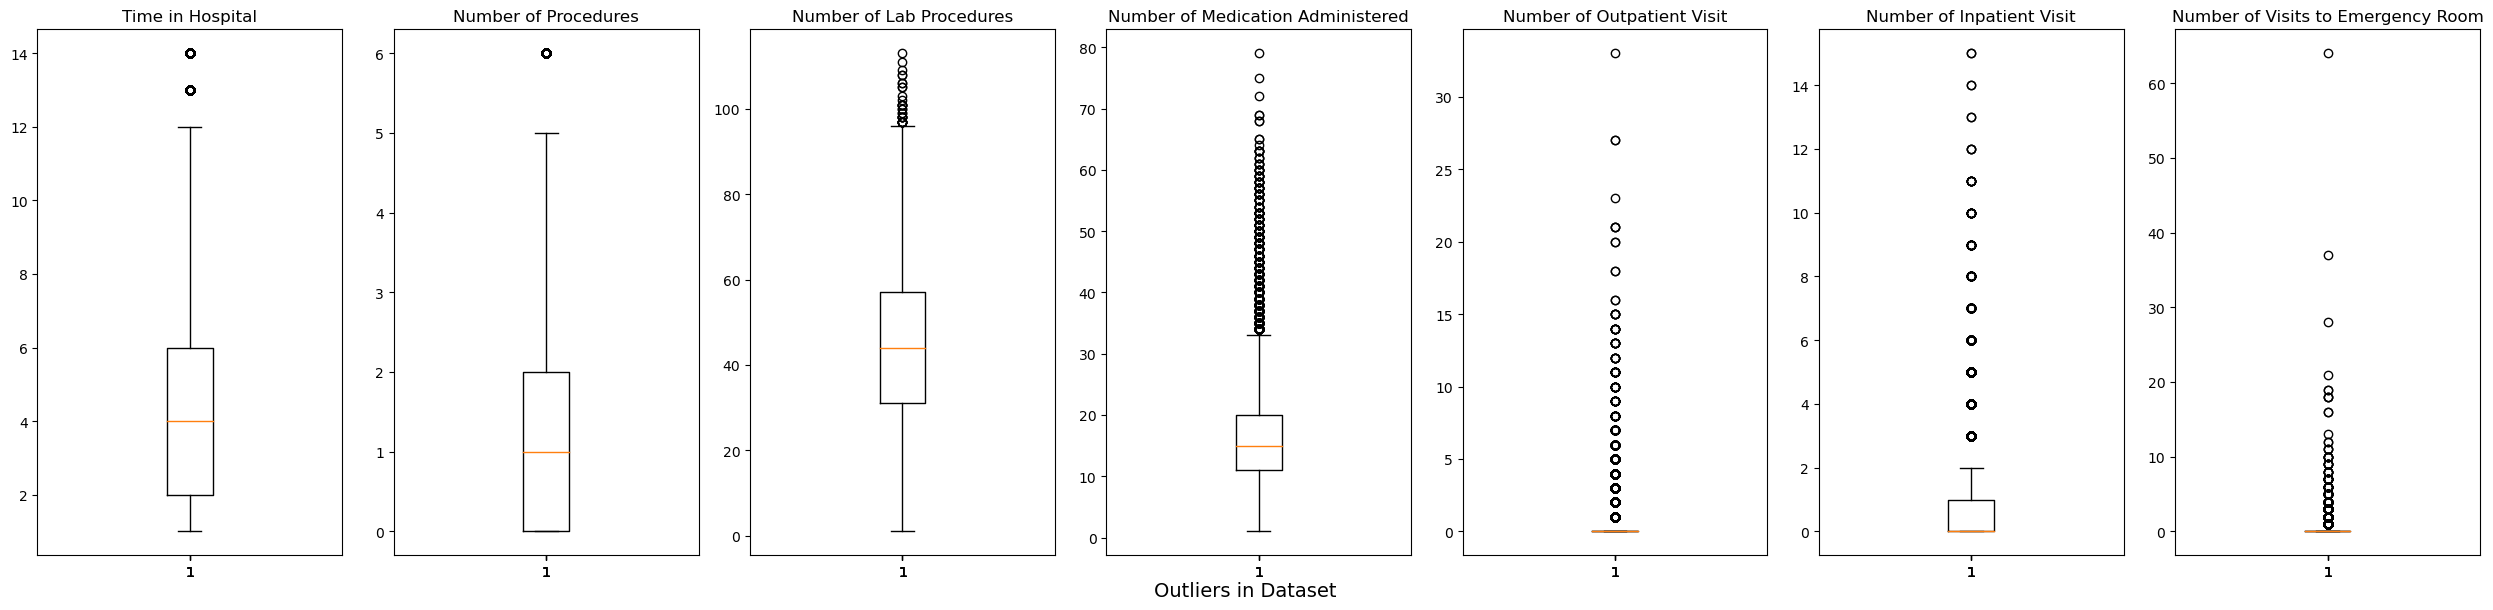

In [9]:
fig, axs = plt.subplots(1, 7, figsize=(25, 6), sharex=True) # Settings for the box plots

axs[0].boxplot(time) # Boxplot for 'time_in_hospital'
axs[0].set_title('Time in Hospital') # Setting title for the plot

axs[1].boxplot(proc) # Boxplot for 'number_of_procedures'
axs[1].set_title('Number of Procedures') # Setting title for the plot

axs[2].boxplot(lab_proc) # Boxplot for 'number_of_lab_procedures'
axs[2].set_title('Number of Lab Procedures') # Setting title for the plot

axs[3].boxplot(medic) # Boxplot for 'number_of_mdeication_administered'
axs[3].set_title('Number of Medication Administered') # Setting title for the plot

axs[4].boxplot(outpatient) # Boxplot for 'number_of_outpatient_visit'
axs[4].set_title('Number of Outpatient Visit') # Setting title for the plot

axs[5].boxplot(inpatient) # Boxplot for 'number_of_inpatient_visit'
axs[5].set_title('Number of Inpatient Visit') # Setting title for the plot

axs[6].boxplot(emergency) # Boxplot for 'number_of_visits_to_emergency_room'
axs[6].set_title('Number of Visits to Emergency Room') # Setting title for the plot

fig.text(0.5, 0.006, 'Outliers in Dataset', ha='center', va='center', fontsize=14) # Settings for 'xlabel'

plt.tight_layout() # Setting the layout for the plots
plt.show() # Showing the plots

## Relationship Between Variables

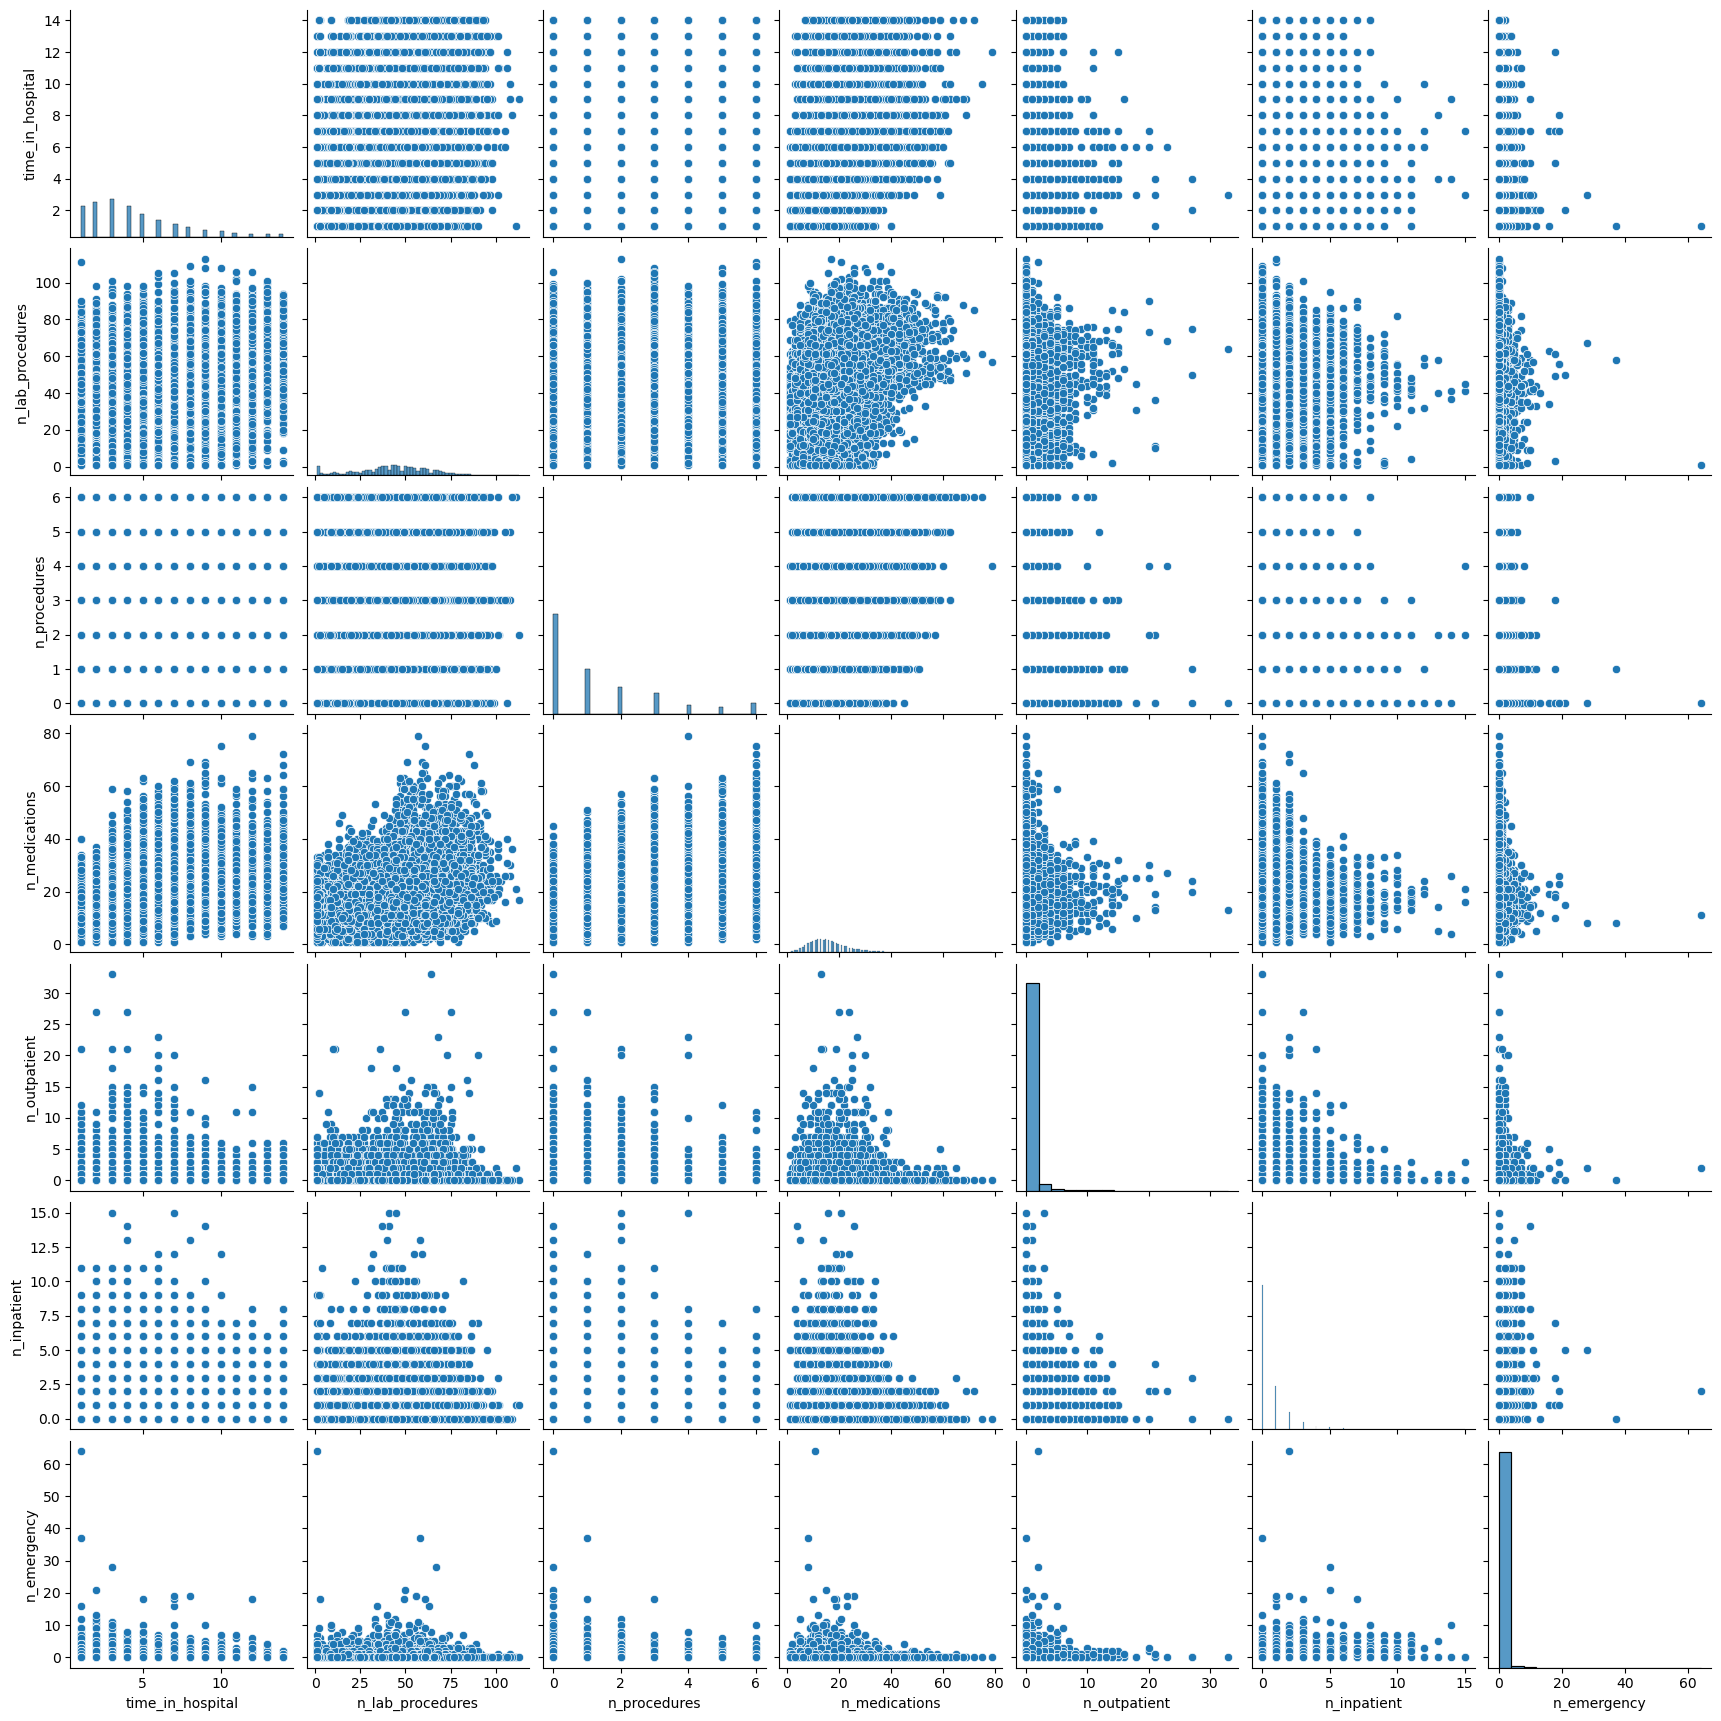

In [10]:
sns.pairplot(dataset) # Using pair-plot to find relationship between all the numerical variables in the dataset
plt.show() # Showing the plot

## Unnecessary Noise in Data 

In [11]:
speciality = pd.DataFrame(dataset['medical_specialty']) # Extracting 'physician_speciality' data
diag = pd.DataFrame(dataset['diag_1']) # Extracting 'primary_diagnosis' data
sec_diag = pd.DataFrame(dataset['diag_2']) # Extractung 'secondary_diagnosis' data
add_sec_diag = pd.DataFrame(dataset['diag_3']) # Extracting 'additonal_secondary_diagnosis' data

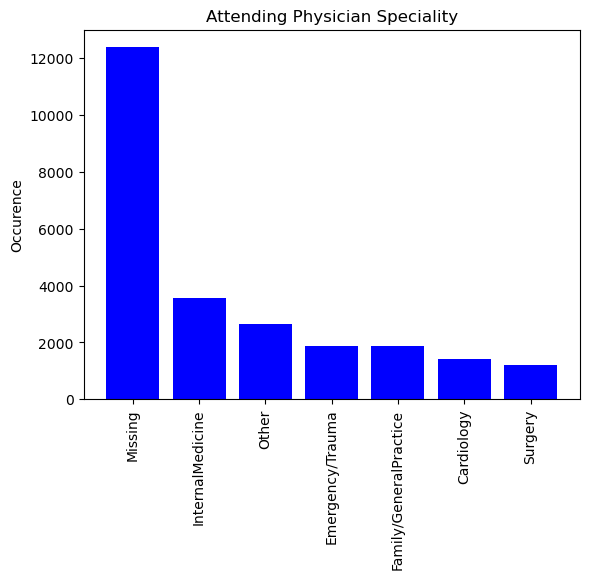

In [12]:
counter_1 = pd.DataFrame(speciality.value_counts()) # Counting occurences
counter_1.columns = ['counter_1'] # Giving output column a name
counter_1 = counter_1.reset_index(inplace = False) # Treating index as a column

plt.bar(counter_1['medical_specialty'], counter_1['counter_1'], color = 'blue') # Settings for the bar chart

plt.xticks(rotation = 90) # Rotating the labels at the x-axis
plt.ylabel('Occurence') # y-axis label 
plt.title('Attending Physician Speciality') # Bar chart title
plt.show() # Displaying the chart

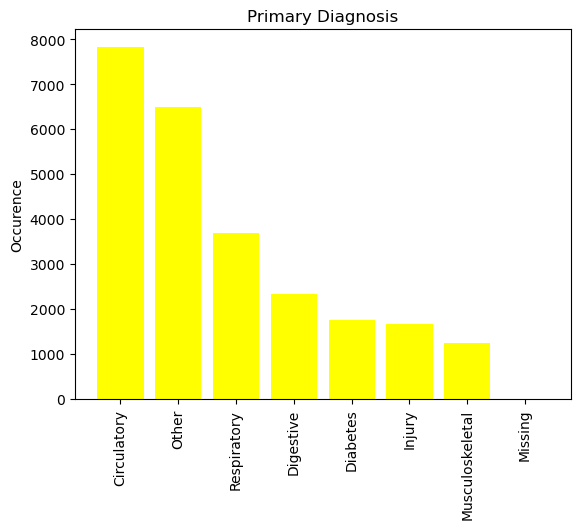

In [13]:
counter_2 = pd.DataFrame(diag.value_counts()) # Counting occurences
counter_2.columns = ['counter_2'] # Giving output column a name
counter_2 = counter_2.reset_index(inplace = False) # Treating index as a column

plt.bar(counter_2['diag_1'], counter_2['counter_2'], color = 'yellow') # Settings for the bar chart

plt.xticks(rotation = 90) # Rotating the labels at the x-axis
plt.ylabel('Occurence') # y-axis label 
plt.title('Primary Diagnosis') # Bar chart title
plt.show() # Displaying the chart

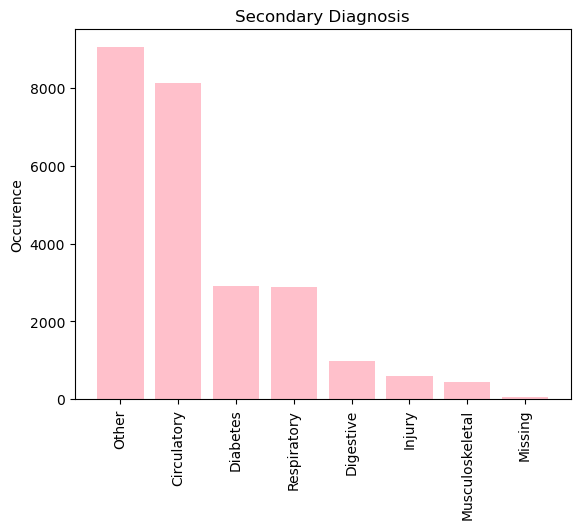

In [14]:
counter_3 = pd.DataFrame(sec_diag.value_counts()) # Counting occurences
counter_3.columns = ['counter_3']# Giving output column a name
counter_3 = counter_3.reset_index(inplace = False) # Treating index as a column

plt.bar(counter_3['diag_2'], counter_3['counter_3'], color = 'pink') # Settings for the bar chart

plt.xticks(rotation = 90) # Rotating the labels at the x-axis
plt.ylabel('Occurence') # y-axis label 
plt.title('Secondary Diagnosis') # Bar chart title
plt.show() # Displaying the chart

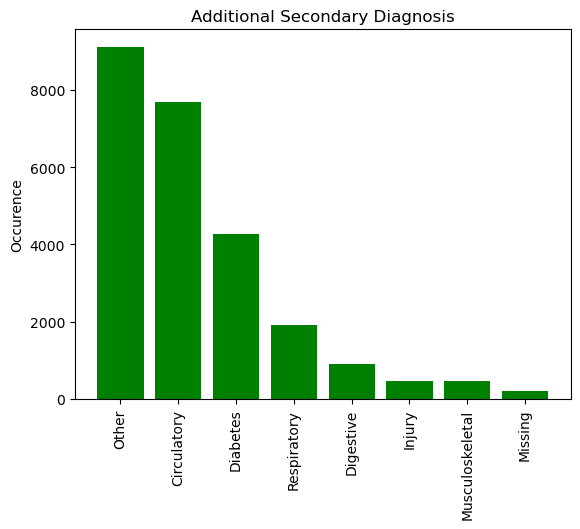

In [23]:
counter_4 = pd.DataFrame(add_sec_diag.value_counts()) # Counting occurences
counter_4.columns = ['counter_4'] # Giving output column a name
counter_4 = counter_4.reset_index(inplace = False) # Treating index as a column

plt.bar(counter_4['diag_3'], counter_4['counter_4'], color = 'green') # Settings for the bar chart

plt.xticks(rotation = 90) # Rotating the labels at the x-axis
plt.ylabel('Occurence') # y-axis label 
plt.title('Additional Secondary Diagnosis') # Bar chart title
plt.show() # Displaying the chart

# Data Pre-Processing

## Removing Outliers

### Removing Outliers Using Z-Score

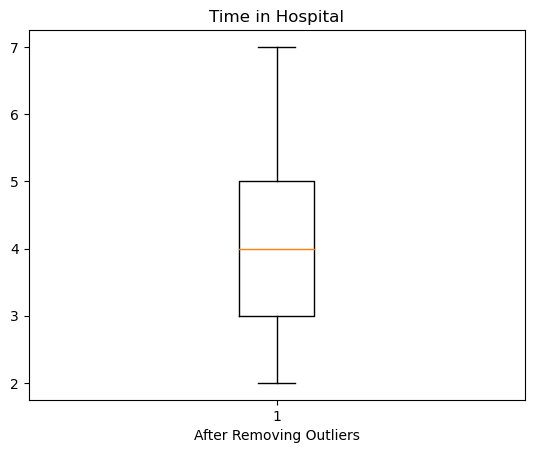

In [43]:
dataset['z_score_time'] = zscore(dataset['time_in_hospital']) # Calculating 'z-score' for time in hospital
updated_dataset = dataset[abs(dataset['z_score_time']) <=1] # Removing outliers from time in hospital 

updated_time = updated_dataset['time_in_hospital'].to_numpy() # Extracting 'time_in_hospital' data

plt.boxplot(updated_time) # Displaying the outliers using boxplot

plt.xlabel('After Removing Outliers')
plt.title('Time in Hospital')
plt.show() # Showing the plot

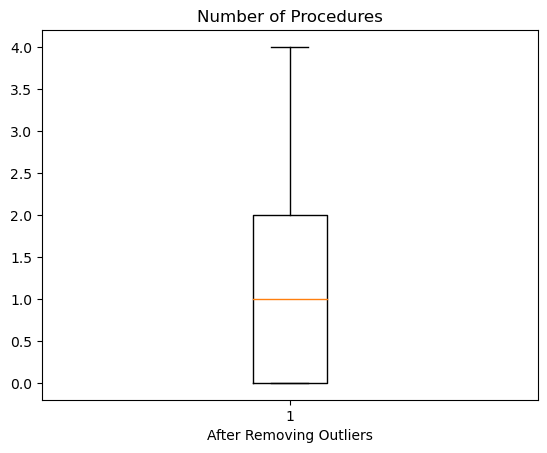

In [44]:
dataset['z_score_proc'] = zscore(dataset['n_procedures']) # Calculating 'z-score' for number of procedures
updated_dataset = dataset[abs(dataset['z_score_proc']) <=2] # Removing outliers from number of procedures

updated_proc = updated_dataset['n_procedures'].to_numpy() # Extracting 'number_of_procedures' data

plt.boxplot(updated_proc) # Displaying the outliers using boxplot

plt.xlabel('After Removing Outliers')
plt.title('Number of Procedures')
plt.show() # Showing the plot

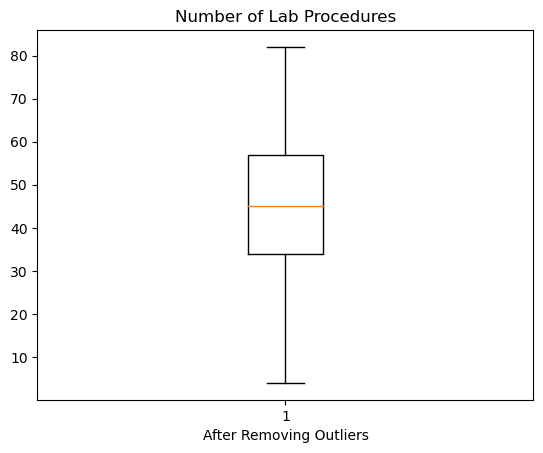

In [45]:
dataset['z_score_lab'] = zscore(dataset['n_lab_procedures']) # Calculating 'z-score' for number of lab procedures
updated_dataset = dataset[abs(dataset['z_score_lab']) <=2] # Removing outliers from number of lab procedures

updated_lab_proc = updated_dataset['n_lab_procedures'].to_numpy() # Extracting 'number_of_lab_procedures data

plt.boxplot(updated_lab_proc) # Displaying the outliers using boxplot

plt.xlabel('After Removing Outliers') # Xlabel for the plot
plt.title('Number of Lab Procedures') # Title of the plot
plt.show() # Showing the plot

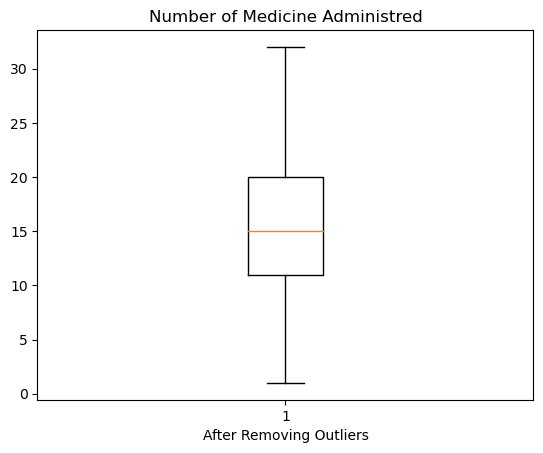

In [46]:
dataset['z_score_medic'] = zscore(dataset['n_medications']) # Calculating 'z-score' for number of medication adminster
updated_dataset = dataset[abs(dataset['z_score_medic']) <=2] # Removing outliers from number of medication adminstered

updated_medic = updated_dataset['n_medications'].to_numpy() # Extracting 'number_of_medication' data

plt.boxplot(updated_medic) # Displaying the outliers using boxplot

plt.xlabel('After Removing Outliers') # Xlabel for the plot
plt.title('Number of Medicine Administred') # Title of the plot
plt.show() # Showing the plot

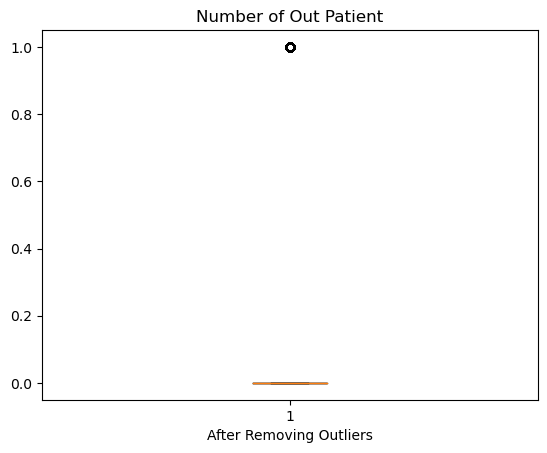

In [47]:
dataset['z_score_out'] = zscore(dataset['n_outpatient']) # Calculating 'z-score' for number of out patient during hospital stay
updated_dataset = dataset[abs(dataset['z_score_out']) <=1] # Removing outliers from number of medication adminstered


updated_outpatient = updated_dataset['n_outpatient'].to_numpy() # Extracting 'number_of_out_patient' data

plt.boxplot(updated_outpatient) # Displaying the outliers using boxplot

plt.xlabel('After Removing Outliers') # Xlabel for the plot
plt.title('Number of Out Patient') # Title of the plot
plt.show() # Showing the plot

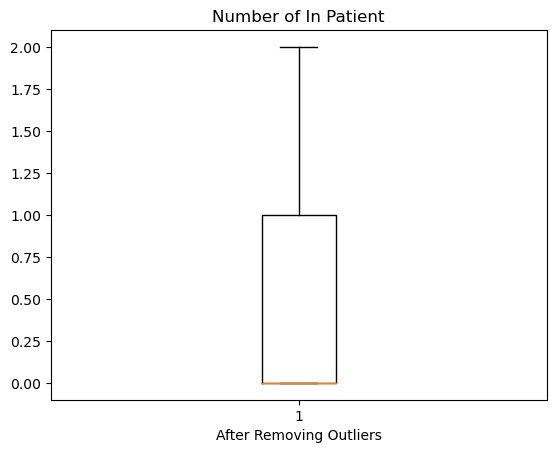

In [48]:
dataset['z_score_in'] = zscore(dataset['n_inpatient']) # Calculating 'z-score' for number of in patient during hospital stay  
updated_dataset = dataset[abs(dataset['z_score_in']) <=2] # Removing outliers from number of in patient during hospital stay

updated_inpatient = updated_dataset['n_inpatient'].to_numpy() # Extracting 'number_of_inpatient' data

plt.boxplot(updated_inpatient) # Displaying the outliers using boxplot

plt.xlabel('After Removing Outliers') # Xlabel for the plot
plt.title('Number of In Patient') # Title of the plot
plt.show() # Showing the plot

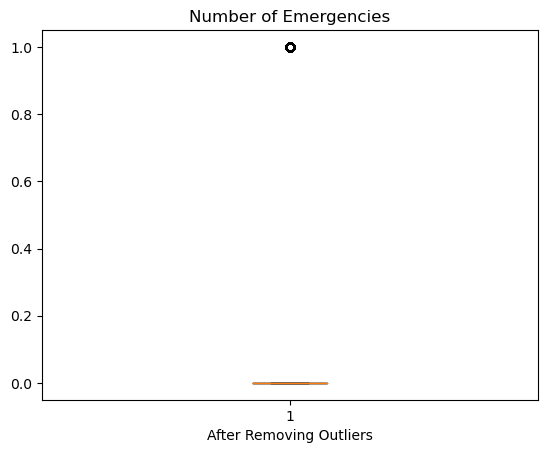

In [49]:
dataset['z_score_emer'] = zscore(dataset['n_emergency']) # Calculating 'z-score' for number of emergencies 
updated_dataset = dataset[abs(dataset['z_score_emer']) <=1] # Removing outliers from number of emergencies 


updated_emergency = updated_dataset['n_emergency'].to_numpy() # Extracting 'number_of_emergency_visits' data

plt.boxplot(updated_emergency) # Displaying the outliers using boxplot

plt.xlabel('After Removing Outliers') # Xlabel for the plot
plt.title('Number of Emergencies') # Title of the plot
plt.show() # Showing the plot

### Restructuring Dataset

In [50]:
updated_dataset = updated_dataset.drop('z_score_time', axis = 1) # Droping 'z-score' data
updated_dataset = updated_dataset.drop('z_score_proc', axis = 1) # Droping 'z-score' data 
updated_dataset = updated_dataset.drop('z_score_lab', axis = 1) # Droping 'z-score' data
updated_dataset = updated_dataset.drop('z_score_medic', axis = 1) # Droping 'z-score' data 
updated_dataset = updated_dataset.drop('z_score_out', axis = 1) # Droping 'z-score' data 
updated_dataset = updated_dataset.drop('z_score_in', axis = 1) # Droping 'z-score' data 
updated_dataset = updated_dataset.drop('z_score_emer', axis = 1) # Droping 'z-score' data 

## Removing Unnecessary Noise 

In [157]:
updated_dataset = updated_dataset[~updated_dataset['medical_specialty'].isin(['Missing', 'Other'])] # Removing 'missing' & 'other' from attending physician speciality column
updated_dataset = updated_dataset[~updated_dataset['diag_1'].isin(['Missing', 'Other'])] # Removing 'missing' & 'other' from primary diagnosis column
updated_dataset = updated_dataset[~updated_dataset['diag_2'].isin(['Missing', 'Other'])] # Removing 'missing' & 'other' from secondary diagnosis column
updated_dataset = updated_dataset[~updated_dataset['diag_3'].isin(['Missing', 'Other'])] # Removing 'missing' & 'other' from additional diagnosis column

## Extracting Dependent & Independent Variable

### Independent Variable

In [158]:
X = updated_dataset.iloc[:, :-1].values # Extracting independent variables
X = pd.DataFrame(X) # Converting into data frame
X.head() # Printing the results

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,[90-100),5,62,0,20,0,0,0,InternalMedicine,Respiratory,Circulatory,Circulatory,no,high,yes,yes
1,[50-60),4,54,5,27,0,0,0,Cardiology,Circulatory,Circulatory,Diabetes,no,high,yes,yes
2,[60-70),2,32,6,12,0,0,0,Family/GeneralPractice,Circulatory,Circulatory,Diabetes,no,no,yes,yes
3,[80-90),3,59,1,15,0,0,0,InternalMedicine,Circulatory,Circulatory,Diabetes,no,high,yes,yes
4,[80-90),11,30,3,21,0,3,0,Family/GeneralPractice,Circulatory,Circulatory,Circulatory,no,no,yes,yes


### Dependent Variable

In [159]:
y = updated_dataset.iloc[:, -1].values # Extracting dependent variables
print(y) # Printing the results

['no' 'no' 'no' ... 'no' 'no' 'no']


## Encoding

### Dependent Variable

In [160]:
label_encoder = LabelEncoder() # Initialzing the encoder
y_encoded = label_encoder.fit_transform(y) # Encoding
print(y_encoded) # Printing the results

[0 0 0 ... 0 0 0]


### Independent Variable

In [161]:
ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [0, 8, 9, 10, 11, 12, 13, 14, 15])], remainder = 'passthrough')
X_encoded = ct.fit_transform(X) # Encoding independent variable
print(X_encoded) # Printing the results

[[0.0 0.0 0.0 ... 0 0 0]
 [0.0 1.0 0.0 ... 0 0 0]
 [0.0 0.0 1.0 ... 0 0 0]
 ...
 [0.0 0.0 0.0 ... 0 0 0]
 [0.0 1.0 0.0 ... 0 0 0]
 [0.0 1.0 0.0 ... 0 0 0]]


### Feature Selection

In [162]:
md = RandomForestClassifier() # Initializing random forest classifier
rfe = RFE(md, n_features_to_select = 12)  # Selecting 12 features
X_selected = rfe.fit_transform(X_encoded, y_encoded) # Fitting the model on independent variable

## Train & Test Split

In [164]:
X_train, X_test, y_train, y_test= train_test_split(X_selected_standardized, y_encoded, test_size = 0.2, random_state = 0) # Spliting Into Train & Test Set

# Predictor

In [165]:
xgboost = XGBClassifier(use_label_encoder = False, objective = 'binary:logistic', eval_metric = 'logloss', verbosity = 0)# Initializing the model
model = xgboost.fit(X_train, y_train) # Training The Model

In [166]:
predict = model.predict(X_test) # Predicting

# Evaluation

## Accuracy

In [181]:
accuracy_1 = accuracy_score(y_test, predict) # Calculating the accuracy percentage of the model
print(f"Accuracy: {round(accuracy * 100)}%") # Printing the Results

Accuracy: 57%


## F1 Score

In [187]:
f1 = f1_score(y_test, predict, average = 'macro') # Intializing the model
print(f"F1 Score: {round(f1)}") # Printing results

F1 Score: 1


## Cross Validation

In [190]:
cv = cross_validate(model, X_encoded, y_encoded, cv=5, scoring='accuracy', return_train_score=False)
avg_accu = cv_results['test_score'].mean()
print(f"Average Accuracy: {round(avg_accu * 100)}%") # Printing the Result

Average Accuracy: 58%


XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX